# Sample selection
The first step for creating a validation dataset is selecting the set of images for the analysis. The sample selection needs to balance the practical problem that the time needed for manual validation of images is a function of image area with the need to sample a sufficiently high number of regions and locations to be representative of the Arctic sea ice cover throughout the melt season. We address this by selecting 9 locations spanning the circumpolar Marginal Ice Zone. Within these 9 locations, we choose images at 4 different spatial scales. The largest number of samples come from the smallest spatial scales, letting us better sample the range of meteorological conditions, without requiring prohibitively large amounts of person-hours for manual validation. This notebook steps through the sample selection procedure. Along the way, we generate the initial sample list, produce the tables summarizing the sample selection for the paper, and produce map figures for the paper.

# TBD
* Separate out the data download script from the generation of the list of cases. It would be ideal if I can use a random seed and have a fully reproducible sample selection process. Data download should be doable with the cylc file, too.
* Case list needs to have the columns required for IFT

* Multi-step methods:
    1. Generate list of 100 km by 100 km scenes
    2. Qualitative assessment step
        - Full set of images with cloud information
        - Sub-set of images have visible floes
    3. Possibly continue until each site has the same number of labeled images? What's enough?
    4. Extending cases: 
        - randomly select image with visible floes, choose end date, run the tracking algorithm for n days
        - select superset scenes, i.e. 500 km cases containing the 100 km images. How much does the result change? We may have some change due to the histogram equalization stuff.
    5. Randomly assigning floe labeling task
        - assign one list for analyzing, another list for reviewing
        - choose 6 scenes per person that overlap with another person's assignment. Need special case number for these. This makes a set of 30 images where we can look at the uncertainty due to different people labeling floes.



# Data file structure
Small images are saved in the github repository currently for convenience. During project development, we are storing the full set of images and output on Google Drive and on files.brown.edu, and will eventually place the data in a repository (probably the Brown Data Repository).  

```
<data_loc>
├── validation_images
│   ├── <region_name>
│   │   ├── <dimensions>
│   │   │   ├── <case_number>_<region_name>_<startdate>
│   │   │   │   ├── landmask.tiff
│   │   │   │   ├── truecolor
│   │   │   │   │   ├── YYYYMMDD.<satellite>.truecolor.250m.tiff
│   │   │   │   ├── falsecolor
│   │   │   │   │   ├── YYYYMMDD.<satellite>.falsecolor.250m.tiff
│   │   │   │   ├── labeled
│   │   │   │   │   ├── <case_number>_<region_name>_<dimensions>_<satellite>_labeled_floes.png
│   │   │   │   │   ├── <case_number>_<region_name>_<dimensions>_<satellite>_labeled_floes.tiff
│   │   │   │   │   ├── <case_number>_<region_name>_<dimensions>_<satellite>_labeled_landfast.png
│   │   │   │   │   ├── <case_number>_<region_name>_<dimensions>_<satellite>_labeled_landfast.tiff
│   │   │   │   │   ├── <case_number>_<region_name>_<dimensions>_<satellite>.psd
│   │   │   │   ├── ift_results
│   │   │   │   │   ├── landmasks
│   │   │   │   │   ├── preprocess
│   │   │   │   │   │   ├── hdf5-files
│   │   │   │   │   │   ├── filenames.jls
│   │   │   │   │   │   ├── floe_props.jls
│   │   │   │   │   │   ├── passtimes.jls
│   │   │   │   │   │   ├── segmented_floes.jls
│   │   │   │   │   │   ├── timedeltas.jls
│   │   │   │   │   ├── soit
│   │   │   │   │   ├── tracker
```

## 


The sample selection process should be guided by random samples but filtered to ensure that there are floes that are possible to detect. We can define a center point for each of the locations, then we can get boxes at each size scale (100 for verification, 500, 1000, 1500 for running the case). 
This current version includes 8 locations. An additional frame centered on Hudson Bay is also a possibility. The samples are taken from a 1000 by 1000 km box; results for Baffin Bay aren't the best because the 1000 km box includes some of the surrounding archipelagos. For each sample, the fraction of grid cells with ice is calculated - not quite the same as sea ice area, since it's north polar stereographic, but this should be effective for the goal of checking whether any ice is present.

Idea: Generate a much larger sample with the random sample, then take a stratified sample from the random sample so that we get a better range of times of year and better range of sea ice concentrations.

Handling cloud fraction:
- MODIS cloud fraction dataset. Pretty large - would need to strategically download data or it will be too much.
- ERA5 cloud fraction - not sure how well the ERA5 cloud fraction works, and it's a different grid, but it would be convenient.
- Rely on manual identification?


Some tasks:
- Collaboratively decide on center locations for the case study boxes
- Learn how to set up list of cases to run. IFT should get run on the same bounding box for all dates, the validation box will change for each date. I'd like to run it at least twice to check for the effects of scale (e.g. 1500 km and 500 km boxes)
- Choose a cloud dataset
- Decide on the corner coordinates. The center should be for the 100 km box, however the larger boxes will not necessarily be centered. Also, the large scale pictures may only be possible for a few locations.
- Set up example folder structure and spreadsheet with list of files and status


Notes:
The sampling isn't fully reproducible. I had to re-run some par

# Sampling strategy
We perform stratified random sampling to select a set of images for the validation dataset. First, nine regions spanning the circumpolar Arctic seasonal ice zones were selected (Figure 1, Table 1). The regions were selected to have equal area. 
The file `setup_locations.py` makes a CSV file `data/metadata/region_definitions.csv`. We use the NSIDC Sea Ice Concentration Climate Data Record (SIC CDR) to identify periods of time that each region contains some overlap with the sea ice region. We acknowledge that uncertainty in SIC CDR is high during the summer. Since the purpose of using the SIC CDR in the random sampling is to find a wide range of sea ice conditions, rather than to make inferences about sea ice physics in these regions, we consider the SIC CDR suitable for this purpose.

Within each region, we follow the following procedure
1. Randomly select a point in space (x, y)
2. While no passing time is found:
3. Randomly select a point in time $t$ such that $t$ is within the range of times where the region has  




For each region:
* Uniformly sample $N_{max}$ center points from within the 1000 km box.
* For each of these points, follow the procedure:
    * Randomly choose a start year and a date between February and October
    * Generate a 100 km box centered on the center point
    * Check based on NSIDC sea ice concentration (SIC) that the average ice concentration in the 100 km box centered on the point is at least 15%.
    * If the selection passes the SIC and CF checks:
        * Add date and center point to list of cases and increment the number of cases. 
        * For each date up to date + 24H:
            * Check the SIC and CF checks
        * If no days pass the check, save date + 24H as the end_date
        * If at least one day passes the check, save the last passing day + 24H as the end_date.
    * Check the number of cases. 
        * If the minimum number of cases per region is met, move to the next region.
    
The results form a table with the index being the case number and columns "region", "start_date", "end_date", "upper_right_lat", "


Afterward: 
- Calculate fraction of land pixels using the actual land mask
- Describe method for estimating cloud fraction
- Calculate cloud fraction using 


# Period of time with sea ice in each region
We first examine the time period with sea ice extent surpassing a threshold of (500 km2? 5%?) for each month.
- Code is already setup in notebook
- Port the code to a script, save the time series of sea ice concentration for each region
- Check how many of the validation images are outside of this time window
- Make table with the cutoff dates
- Note that in an early version of the sampling routine, there was an error in the sea ice concentration calculation where the coastal mask was treated as sea ice. This resulted in 25 images where there is no sea ice present. These cases were retained to provide a stress-test for the algorithm--any "floes" detected in these images are easily determined to be false positives.
- Check how many images have no overlap with the 15-85% sea ice concentration data. This part should be fine still - the coast mask error wouldn't affect it.

Evaluation cases
- 9 regions
- At least 15 cases per region (some cases with more than 1 day)
  - This gives us 135 cases + however many we do the tracking for.

Things to figure out:
- test if the fetch_data.sh script works for the eastern hemisphere (i.e. max lat < min lat), if not check if the north polar stereographic system works
- for the calibration, we'll want to do test / train splits: need enough data to separate and still have statistical significance

Sea of Okhostk: is there ever sea ice in September?

In [1]:
import os
import pyproj
import numpy as np
import pandas as pd
import xarray as xr

# Two parts:
# 1: Generate a randomly sampled set of candidate locations
# 2: Filter this list by sea ice fraction
# 3: Stratifying by month between the beginning and end months for the locations

In [2]:
sic_dataloc = '/Users/dwatkin2/Documents/research/data/nsidc_daily_cdr/'
regions = pd.read_csv('../data/metadata/region_definitions.csv', index_col='region')

def compute_sic(left_x, right_x, bottom_y, top_y, sic_data):
    """Computes the sea ice extent as a fraction of total area within the region bounded
    by <left_x>, <right_x>, <bottom_y>, and <top_y> using the netcdf file <sic_data>. Assumes
    that sic_data is the NSIDC SIC CDR."""

    x_idx = (sic_data.xgrid >= left_x) & (sic_data.xgrid <= right_x)
    y_idx = (sic_data.ygrid >= bottom_y) & (sic_data.ygrid <= top_y)
    
    with_ice = ((sic_data.sel(x=x_idx, y=y_idx)['cdr_seaice_conc'] > 0.15) & \
                (sic_data.sel(x=x_idx, y=y_idx)['cdr_seaice_conc'] <= 1))
    coast_mask = (sic_data.sel(x=x_idx, y=y_idx)['cdr_seaice_conc'] > 1).sum() 
    total_area_pixels = np.prod(with_ice.shape)
    sic_area_pixels = with_ice.sum().data
    sic_mean = (sic_data.sel(x=x_idx, y=y_idx).where(with_ice))['cdr_seaice_conc'].mean().data
    return {'sea_ice_fraction': np.round(sic_area_pixels/(total_area_pixels - coast_mask.data), 3),
            'mean_sea_ice_concentration': np.round(sic_mean, 3)}

In [11]:
sif_data = pd.read_csv('../data/metadata/daily_sea_ice_fraction.csv', index_col=0, parse_dates=True)
threshold = 0.05
end_doy = sif_data.groupby(sif_data.index.dayofyear).quantile(0.90).apply(lambda x: x[x >= threshold].index.max())
start_doy = pd.Series(pd.to_datetime('2003-03-01').dayofyear, index=end_doy.index)

In [24]:
pd.to_datetime('2000-01-01') + pd.to_timedelta(274, unit='d')

Timestamp('2000-10-01 00:00:00')

In [29]:

start_month = (pd.to_datetime('2000-01-01') + pd.to_timedelta(start_doy[region], unit='d')).month
end_month = (pd.to_datetime('2000-01-01') + pd.to_timedelta(end_doy[region] - 1, unit='d')).month
samples_by_month = pd.Series(0, index=np.arange(start_month, end_month+1))
samples_by_month

3    0
4    0
5    0
6    0
7    0
8    0
9    0
dtype: int64

In [4]:
for name, row in regions.iterrows():
    break
row

center_lat    7.500000e+01
center_lon   -6.500000e+01
center_x     -5.588197e+05
center_y     -1.535345e+06
left_x       -1.121320e+06
right_x       3.680300e+03
lower_y      -2.535345e+06
top_y        -5.353445e+05
Name: baffin_bay, dtype: float64

In [ ]:

def find_candidates(n_samples, region_info, dx, start_doy, end_doy, sic_path,
                    sif_threshold=0.25, margin=250, start_year=2003, end_year=2022,
                    min_samples_per_month=10):
    """Generates a list of candidate locations for the validation dataset. 
    n: sets the number of candidates to generate.
    region_info: a row from the region_definitions table.
    start_doy and end_doy: series of day of year with the region names as the index.
    dx is the dimension in km of the sample scene.
    sic_path: path to folder with the NSIDC CDR data.
    sif_threshold: between 0 and 1. The ice fraction needed to retain a sample.
    margin: distance in km that the center needs to be from the edge of the region boundary.
    
    
    """
    
    dx_meters = dx*1e3
    region = region_info.name
    left_x = region_info.left_x
    right_x = region_info.right_x
    lower_y = region_info.lower_y
    upper_y = region_info.top_y

    # calculations are done in polar stereographic
    # use pyproj to convert back to lon/lat for final table
    crs0 = pyproj.CRS('WGS84')
    crs1 = pyproj.CRS('epsg:3413')
    transformer_ll = pyproj.Transformer.from_crs(crs1, crs_to=crs0, always_xy=True)
    
    # we keep track of the number of samples generated per month
    # the range is set up this way so that we don't get extra months in 
    # leap years. for other uses the start and end doy could be adjusted differently.
    start_month = (pd.to_datetime('2000-01-01') + pd.to_timedelta(start_doy[region], unit='d')).month
    end_month = (pd.to_datetime('2000-01-01') + pd.to_timedelta(end_doy[region] - 1, unit='d')).month
    samples_by_month = pd.Series(0, index=np.arange(start_month, end_month+1))

    
    candidates = []
    
    def in_box(x, y, margin):
        """Convenience function that checks whether point x, y is in region.
        Returns True if x, y in the box."""
        if left_x <= x:
            if right_x >= x:
                if lower_y <= y:
                    if top >= y:
                        return True
        return False
    
    while np.any(samples_by_month < min_samples_per_month):
        # Randomly select date from months with not enough samples
        year = np.random.choice(np.arange(2003, 2023))
        remaining_months = list(samples_by_month[samples_by_month < min_samples_per_month].index)
        month = np.random.choice(remaining_months)
        days_in_month = pd.to_datetime(str(year) + '-' + str(month) + '-01').daysinmonth
        day = np.random.choice(np.arange(1, days_in_month+1))
        date = str(year) + str(month).zfill(2) + str(day).zfill(2)
        
        # Load SIC data for the date. If any MIZ regions, randomly select center point
        # with sea ice concentration between 15 and 85 percent, otherwise pass    
        min_ice = 0.15
        max_ice = 0.85
        
        files = os.listdir(sic_path + str(year))
        if 'f17' in files[0]:
            f = 'seaice_conc_daily_nh_' + row.start_date.strftime('%Y%m%d') + '_f17_v04r00.nc'
        else:
            f = 'seaice_conc_daily_nh_' + row.start_date.strftime('%Y%m%d') + '_f13_v04r00.nc'
            
        with xr.open_dataset(sic_dataloc + str(year) + '/' + f) as sic_data:
            
            # generate center point
            X, Y = np.meshgrid(sic_data.xgrid, sic_data.ygrid)
            miz = (sic_data['cdr_seaice_conc'] >= min_ice) & (sic_data['cdr_seaice_conc'] <= max_ice)
            miz = np.ravel(miz.squeeze())
            xoptions = np.ravel(X)[subset]
            yoptions = np.ravel(Y)[subset]
            inside = np.array([in_box(x, y, box) for x, y in zip(xoptions, yoptions)])
    
            if np.any(inside):
                ii = np.random.choice(np.arange(len(xoptions))[inside])
                
                # get x, y coordinates
                x0 = xoptions[ii]
                y0 = yoptions[ii]

                # define scene centered at 
                left_x0 = x0 - dx_meters/2
                right_x0 = x0 + dx_meters/2
                lower_y0 = y0 - dx_meters/2
                upper_y0 = y0 + dx_meters/2
                
                sic_results = compute_sic(left_x0, right_x0, lower_y0, upper_y0, sic_data)
        
#         candidate_validation_table.loc[idx, 'sea_ice_fraction'] = sic_results['sea_ice_fraction']
#         candidate_validation_table.loc[idx, 'mean_sea_ice_concentration'] = sic_results['mean_sea_ice_concentration']
        
        else:
            result = check_sic(sic_dataloc + str(year) + '/' + f, box)
            if len(result) > 0:
                center_x, center_y, with_ice = result
                lon0, lat0 = transformer_ll.transform(center_x, center_y)
                candidates.append([region, pd.to_datetime(date).strftime('%Y-%m-%d'), lon0, lat0, center_x, center_y, with_ice])               
                months_sampled[month] += 1
        # make this one a function that returns either None or with_ice.data

candidates = pd.DataFrame(candidates, columns=['region', 'start_date', 'center_lon', 'center_lat', 'center_x', 'center_y', 'ice_frac'])
# chukchi_march = candidates.copy()

candidates['month'] = pd.to_datetime(candidates['start_date'].values).month
candidates.groupby(['region', 'month']).count().pivot_table(index='region', columns='month', values='start_date')

candidates['ice_frac'] = candidates['ice_frac'].astype(float).round(2)

In [62]:
# TBD
sic_dataloc = '/Users/dwatkin2/Documents/research/data/nsidc_daily_cdr/'
candidate_validation_table = pd.read_csv('../../data/candidate_validation_table.csv', index_col=0)
candidate_validation_table['start_date'] = pd.to_datetime(candidate_validation_table['start_date'].values)
for idx, row in candidate_validation_table.iterrows():
    year = row.start_date.year
    files = os.listdir(sic_dataloc + str(year))
    if 'f17' in files[0]:
        f = 'seaice_conc_daily_nh_' + row.start_date.strftime('%Y%m%d') + '_f17_v04r00.nc'
    else:
        f = 'seaice_conc_daily_nh_' + row.start_date.strftime('%Y%m%d') + '_f13_v04r00.nc'
    dx = 100e3
    left_x = row.center_x - dx/2
    right_x = row.center_x + dx/2
    bottom_y = row.center_y - dx/2
    top_y = row.center_y + dx/2
    with xr.open_dataset(sic_dataloc + str(year) + '/' + f) as sic_data:
        sic_results = compute_sic(left_x, right_x, bottom_y, top_y, sic_data)
        candidate_validation_table.loc[idx, 'sea_ice_fraction'] = sic_results['sea_ice_fraction']
        candidate_validation_table.loc[idx, 'mean_sea_ice_concentration'] = sic_results['mean_sea_ice_concentration']

In [63]:
all_cases = pd.read_csv('../data/metadata/case_list.csv', index_col=0)
all_cases = all_cases.loc[all_cases.satellite=='aqua'] # only looking at one day at a time
all_cases['start_date'] = pd.to_datetime(all_cases.start_date.values)
all_cases['month'] = all_cases.start_date.dt.month
all_cases.groupby(['region', 'month']).count().pivot_table(index='region', columns='month', values='start_date')

month,3,4,5,6,7,8,9
region,,,,,,,
baffin_bay,3.0,3.0,3.0,3.0,3.0,3.0,3.0
barents-kara_seas,3.0,3.0,3.0,3.0,3.0,3.0,3.0
beaufort_sea,3.0,3.0,3.0,3.0,3.0,3.0,3.0
bering_strait,3.0,3.0,3.0,3.0,3.0,3.0,3.0
chukchi-east_siberian_sea,3.0,3.0,3.0,3.0,3.0,3.0,3.0
greenland_sea,3.0,3.0,3.0,3.0,3.0,3.0,3.0
hudson_bay,3.0,3.0,3.0,3.0,3.0,3.0,3.0
laptev_sea,3.0,3.0,3.0,3.0,3.0,3.0,3.0
sea_of_okhostk,3.0,4.0,3.0,3.0,5.0,3.0,NaN


In [65]:
samples = candidate_validation_table.merge(all_cases.reset_index().loc[:, ['case_number', 'region', 'start_date', 'analyst']],
                                 left_on=['region', 'start_date'], right_on=['region', 'start_date'], how='outer')

In [66]:
samples['status'] = 'Available'
samples.loc[samples.analyst.notnull(), 'status'] = 'Included'
samples.loc[(samples['sea_ice_fraction'] < 0.25) & samples.analyst.isnull(), 'status'] = 'Rejected'

In [67]:
validation_tables = pd.read_csv('../data/validation_tables/qualitative_assessment_tables/all_100km_cases.csv')
validation_tables['start_date'] = pd.to_datetime(validation_tables['start_date'].values)
validation_tables['month'] = validation_tables.start_date.dt.month

validation_tables.columns

Index(['Unnamed: 0', 'case_number', 'long_name', 'region', 'start_date',
       'end_date', 'satellite', 'dx_km', 'visible_sea_ice',
       'visible_landfast_ice', 'visible_floes', 'cloud_fraction',
       'cloud_category', 'artifacts', 'qa_analyst', 'qa_reviewer',
       'fl_analyst', 'fl_reviewer', 'notes', 'fl_analyst_comparison', 'month'],
      dtype='object')

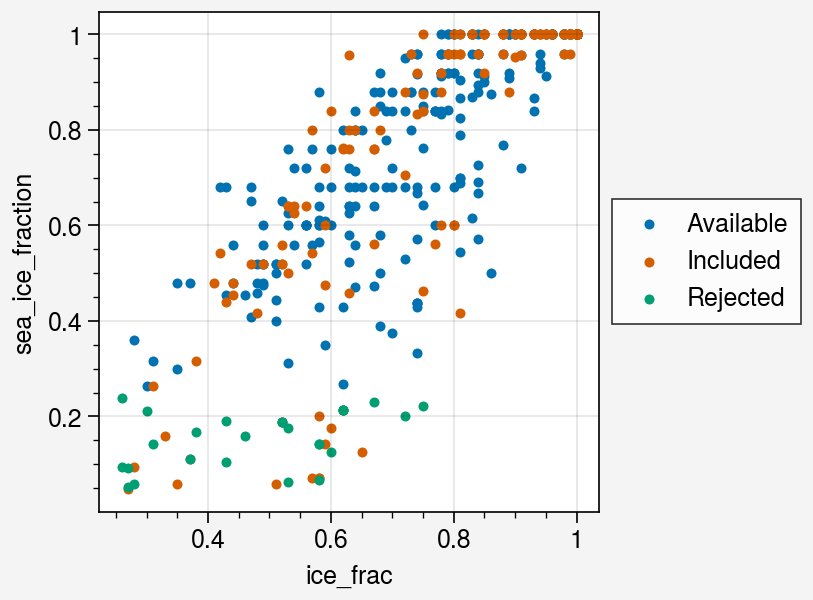

In [71]:
fig, ax = pplt.subplots()
for name, subset in samples.groupby('status'):
    ax.scatter(subset.ice_frac, subset.sea_ice_fraction, marker='.', label=name)
ax.legend(loc='r', ncols=1)

Optional: we can up the number of samples to include less than 0.25 SIC for all locations

Current plan: replace the too-low SIC images.

Check: why extra Chukchi Sea images included? More than 21?? are those the > 100 km cases?

In [68]:
# for region
#    for month 
#         check how many more are needed
#         make a table with the new samples

samples.groupby(['region', 'status']).count()


start_date  center_lon  center_lat  \
region                    status                                          
baffin_bay                Available          47          47          47   
                          Included           22          22          22   
                          Rejected            1           1           1   
barents-kara_seas         Available          45          45          45   
                          Included           21          21          21   
                          Rejected            4           4           4   
beaufort_sea              Available          49          49          49   
                          Included           21          21          21   
bering_strait             Available          37          37          37   
                          Included           21          21          21   
                          Rejected           12          12          12   
chukchi-east_siberian_sea Available          46          46          46   
                          Included           24          24          24   
greenland_sea             Available          48          48          48   
                          Included           21          21          21   
                          Rejected            1           1           1   
hudson_bay                Available          48          48          48   
                          Included           21          21          21   
                          Rejected            1           1           1   
laptev_sea                Available          49          49          49   
                          Included           21          21          21   
sea_of_okhostk            Available          32          32          32   
                          Included           21          21          21   
                          Rejected            7           7           7   

                                     center_x  center_y  ice_frac  month  \
region                    status                                           
baffin_bay                Available        47        47        47     47   
                          Included         22        22        22     22   
                          Rejected          1         1         1      1   
barents-kara_seas         Available        45        45        45     45   
                          Included         21        21        21     21   
                          Rejected          4         4         4      4   
beaufort_sea              Available        49        49        49     49   
                          Included         21        21        21     21   
bering_strait             Available        37        37        37     37   
                          Included         21        21        21     21   
                          Rejected         12        12        12     12   
chukchi-east_siberian_sea Available        46        46        46     46   
                          Included         24        24        24     24   
greenland_sea             Available        48        48        48     48   
                          Included         21        21        21     21   
                          Rejected          1         1         1      1   
hudson_bay                Available        48        48        48     48   
                          Included         21        21        21     21   
                          Rejected          1         1         1      1   
laptev_sea                Available        49        49        49     49   
                          Included         21        21        21     21   
sea_of_okhostk            Available        32        32        32     32   
                          Included         21        21        21     21   
                          Rejected          7         7         7      7   

                                     sea_ice_fraction  \
region                    status                    

In [57]:
samples.loc[(samples.region == 'chukchi-east_siberian_sea') & (samples.status == 'Included')].sort_values('start_date')

,region,start_date,center_lon,center_lat,center_x,center_y,ice_frac,month,new_sic,sea_ice_fraction,mean_sea_ice_concentration,case_number,analyst,status
591,chukchi-east_siberian_sea,2004-07-17,168.777542,69.257931,-1262500.0,1887500.0,1.00,7,NaN,1.00,0.475,196.0,daniel,Included
569,chukchi-east_siberian_sea,2005-07-30,178.768023,74.904451,-1137500.0,1187500.0,1.00,7,NaN,1.00,0.682,198.0,daniel,Included
572,chukchi-east_siberian_sea,2006-06-11,154.510799,74.543225,-562500.0,1587500.0,1.00,6,NaN,1.00,0.686,199.0,daniel,Included
579,chukchi-east_siberian_sea,2006-09-27,-173.595647,74.007638,-1362500.0,1087500.0,0.79,9,NaN,0.96,0.523,200.0,daniel,Included
600,chukchi-east_siberian_sea,2007-07-23,158.818650,76.065433,-612500.0,1387500.0,1.00,7,NaN,1.00,0.500,202.0,daniel,Included
588,chukchi-east_siberian_sea,2009-09-03,-177.614056,78.279690,-937500.0,862500.0,0.93,9,NaN,1.00,0.493,206.0,daniel,Included
561,chukchi-east_siberian_sea,2010-09-29,170.858360,75.691856,-912500.0,1262500.0,1.00,9,NaN,1.00,0.855,208.0,daniel,Included
610,chukchi-east_siberian_sea,2014-04-27,152.271743,75.691856,-462500.0,1487500.0,1.00,4,NaN,1.00,0.914,221.0,daniel,Included
589,chukchi-east_siberian_sea,2014-05-11,146.864390,76.035464,-312500.0,1487500.0,1.00,5,NaN,1.00,0.777,222.0,daniel,Included
575,chukchi-east_siberian_sea,2014-08-08,-172.259659,73.154624,-1462500.0,1112500.0,0.63,8,NaN,0.80,0.552,223.0,daniel,Included


In [ ]:
for case, row in all_cases.iterrows():
    sic_dataloc = '/Users/dwatkin2/Documents/research/data/nsidc_daily_cdr/'
    year = row.start_date.split('-')[0]
    files = os.listdir(sic_dataloc + year)
    if 'f17' in files[0]:
        f = 'seaice_conc_daily_nh_' + row.start_date.replace('-', '') + '_f17_v04r00.nc'
    else:
        f = 'seaice_conc_daily_nh_' + row.start_date.replace('-', '') + '_f13_v04r00.nc'
    
    result = compute_sic(row.center_x, row.center_y, sic_dataloc + year + '/' + f)
    all_cases.loc[case, 'new_sea_ice_fraction'] = result['sea_ice_pixel_fraction']
    all_cases.loc[case, 'mean_sic'] = result['mean_sea_ice_conc'] # SIC within the sea ice covered area
    all_cases.loc[case, 'new_mask_fraction'] = result['mask_fraction']
    all_cases.loc[case, 'n_sic_cdr'] = result['n']

Cutoff for the last day of year is when the median sea ice fraction drops below 0.05 or the last day of September, whichever is earlier.

In [300]:
sic_timeseries = pd.read_csv('../data/metadata/daily_sea_ice_fraction.csv', index_col=0, parse_dates=True)
cutoff_table = []
for region in sic_timeseries:
    p90_value = sic_timeseries[region].groupby(sic_timeseries[region].index.dayofyear).quantile(0.9)
    last_day = p90_value.where(p90_value > 0.05).dropna().index.max()
    month_day = sic_timeseries[region].loc[sic_timeseries[region].index.dayofyear==last_day].index.min().strftime('%b %d')
    cutoff_table.append([regions.loc[region, 'print_title'],  last_day, month_day])
cutoff_table = pd.DataFrame(cutoff_table, columns=['Region', 'DoY', 'Date (non leap year)'])

In [301]:
cutoff_table

,Region,DoY,Date (non leap year)
0,Baffin Bay,274,Sep 30
1,Barents-Kara Seas,273,Sep 30
2,Beaufort Sea,274,Sep 30
3,Bering Strait,223,Aug 11
4,Chukchi-East Siberian Sea,274,Sep 30
5,Greenland Sea,274,Sep 30
6,Hudson Bay,232,Aug 20
7,Laptev Sea,274,Sep 30
8,Sea of Okhostk,178,Jun 27


month,3,4,5,6,7,8,9
region,,,,,,,
baffin_bay,3.0,3.0,3.0,3.0,3.0,3.0,3.0
barents-kara_seas,3.0,3.0,3.0,3.0,3.0,3.0,3.0
beaufort_sea,3.0,3.0,3.0,3.0,3.0,3.0,3.0
bering_strait,3.0,3.0,3.0,3.0,3.0,3.0,3.0
chukchi-east_siberian_sea,3.0,3.0,3.0,3.0,3.0,3.0,3.0
greenland_sea,3.0,3.0,3.0,3.0,3.0,3.0,3.0
hudson_bay,3.0,3.0,3.0,3.0,3.0,3.0,3.0
laptev_sea,3.0,3.0,3.0,3.0,3.0,3.0,3.0
sea_of_okhostk,3.0,4.0,3.0,3.0,5.0,3.0,NaN


In [5]:
crs0 = pyproj.CRS('WGS84')
crs1 = pyproj.CRS('epsg:3413')
# lon0, lat0 = -52.7354, 69.1581 # top right
# lon1, lat1 = -64.1837, 61.2812 # bottom left
lon0, lat0 = -55.3051, 83.3547
lon1, lat1 = -62.8275, 81.8389
transformer_xy = pyproj.Transformer.from_crs(crs0, crs_to=crs1, always_xy=True)
transformer_ll = pyproj.Transformer.from_crs(crs1, crs_to=crs0, always_xy=True)
right, top = transformer_xy.transform(lon0, lat0)
left, bottom = transformer_xy.transform(lon1, lat1)

top_left_lon, top_left_lat = transformer_ll.transform(left, top)
bottom_right_lon, bottom_right_lat = transformer_ll.transform(right, bottom)

In [10]:
','.join([str(np.round(x, 5)) for x in [top_left_lat, top_left_lon, bottom_right_lat, bottom_right_lon]])


'83.00108,-65.92484,82.13953,-53.69472'

In [9]:
# centroid
transformer_ll.transform(0.5*(left + right), 0.5*(top + bottom))

(-59.452920695699184, 82.61222479089614)

In [116]:
def draw_box(center_lon, center_lat, length_x, length_y, return_coords='stere'):
    """Return the corner coordinates for a box centered at center_lon, center_lat
    with side lengths given by length_x and length_y."""
    
    data = find_box(center_lon, center_lat, length_x, length_y, return_coords)

    if return_coords=='stere':
        return([data['left_x'], data['left_x'], data['right_x'], data['right_x'], data['left_x']],
               [data['lower_y'], data['top_y'], data['top_y'], data['lower_y'], data['lower_y']])
    else:
        return (data[['lower_left_lon', 'top_left_lon', 'top_right_lon', 'lower_right_lon', 'lower_left_lon']],
                data[['lower_left_lat', 'top_left_lat', 'top_right_lat', 'lower_right_lat', 'lower_left_lat']])

def find_box(center_lon, center_lat, length_x, length_y, return_coords='stere'):
    """Find the coordinates of each corner for a box centered at center_lon, center_lat with
    side lengths in meters specified by length_x and length_y. If return_coords is stere, then
    use the NSIDC polar stereographic, otherwise return latitude and longitude."""
    
    crs0 = pyproj.CRS('WGS84')
    crs1 = pyproj.CRS('epsg:3413')
    transformer_xy = pyproj.Transformer.from_crs(crs0, crs_to=crs1, always_xy=True)
    transformer_ll = pyproj.Transformer.from_crs(crs1, crs_to=crs0, always_xy=True)
    center_x, center_y = transformer_xy.transform(center_lon, center_lat)
    dx = length_x/2
    dy = length_y/2
    left = center_x - dx
    right = center_x + dx
    top = center_y + dy
    bottom = center_y - dy
    
    topleft_lon, topleft_lat = transformer_ll.transform(left, top)
    topright_lon, topright_lat = transformer_ll.transform(right, top)
    bottomleft_lon, bottomleft_lat = transformer_ll.transform(left, bottom)
    bottomright_lon, bottomright_lat = transformer_ll.transform(right, bottom)
    
    return pd.Series([topleft_lat, topright_lat, bottomleft_lat, bottomright_lat,
                      topleft_lon, topright_lon, bottomleft_lon, bottomright_lon,
                      left, right, bottom, top],
                      index=['top_left_lat', 'top_right_lat', 'lower_left_lat', 'lower_right_lat',
                             'top_left_lon', 'top_right_lon', 'lower_left_lon', 'lower_right_lon',
                             'left_x', 'right_x', 'lower_y', 'top_y']).round(5)

def in_box(x, y, box):
    """Checks whether point x, y is in box. Returns True if x, y in the box."""
    left = box[0][0]
    right = box[0][2]
    bottom = box[1][0]
    top = box[1][1]
    if left <= x:
        if right >= x:
            if bottom <= y:
                if top >= y:
                    return True
    
    return False

def check_sic(path, box, box_size=200e3, min_ice=0.15, max_ice=0.85):
    """Opens NSIDC SIC CDR file at path, and checks if there is enough
    sea ice inside the box with center info in <box> and dimensions <box_size> squared. """
    with xr.open_dataset(path) as sic:
        X, Y = np.meshgrid(sic.xgrid, sic.ygrid)
        subset = (sic['cdr_seaice_conc'] >= min_ice) & (sic['cdr_seaice_conc'] <= max_ice)
        subset = np.ravel(subset.squeeze())
        xoptions = np.ravel(X)[subset]
        yoptions = np.ravel(Y)[subset]
        inside = np.array([in_box(x, y, box) for x, y in zip(xoptions, yoptions)])
    
        if np.any(inside):
            ii = np.random.choice(np.arange(len(xoptions))[inside])
            # get x, y coordinates
            x0 = xoptions[ii]
            y0 = yoptions[ii]
    
            # select data in 100 km box centered at x0, y0
            dx = box_size/2
            x_idx = (sic.xgrid >= x0 - dx) & (sic.xgrid <= x0 + dx)
            y_idx = (sic.ygrid >= y0 - dx) & (sic.ygrid <= y0 + dx)
    
            # compute fraction of grid cells that have some sea ice
            with_ice = ((sic.sel(x=x_idx, y=y_idx)['cdr_seaice_conc'] > 0.15) & (sic.sel(x=x_idx, y=y_idx)['cdr_seaice_conc'] <= 1)).mean()

            # re-adjust so that we know how much is overlapping the coastal mask in the SIC data product
            # (tbd)
            if with_ice.data > 0.25:
                return [x0, y0, with_ice.data]
            else:
                return []
        else:
            return []

def compute_sic(x0, y0, path, dx=100e3, dy=100e3):
    """Computes the fraction of the dx by dy region centered at x0, y0
    using the NSIDC Daily CDR located at path."""
    with xr.open_dataset(path) as sic:

        x_idx = (sic.xgrid >= x0 - dx/2) & (sic.xgrid <= x0 + dx/2)
        y_idx = (sic.ygrid >= y0 - dx/2) & (sic.ygrid <= y0 + dx/2)
        
        with_ice = ((sic.sel(x=x_idx, y=y_idx)['cdr_seaice_conc'] > 0.15) & \
                    (sic.sel(x=x_idx, y=y_idx)['cdr_seaice_conc'] <= 1))
        coast_mask = (sic.sel(x=x_idx, y=y_idx)['cdr_seaice_conc'] > 1).mean() 
        n = np.prod(with_ice.shape)
        return {'sea_ice_pixel_fraction': with_ice.mean().data, 
                'mean_sea_ice_conc': sic.sel(x=x_idx, y=y_idx).where(with_ice)['cdr_seaice_conc'].mean().data,
                'mask_fraction': coast_mask.data, 'n': n}

In [9]:
all_cases = pd.read_csv('../data/metadata/case_list.csv', index_col=0)
all_cases = all_cases.loc[all_cases.satellite=='aqua'] # only looking at one day at a time

It appears that some of the cases shouldn't been included - in particular, I think that I accidently used the coast mask in checking the sea ice fraction. We do want to have cases with significant overlap with coasts. 

In [117]:
import os
all_cases['new_sea_ice_fraction'] = np.nan
all_cases['new_mask_fraction'] = np.nan
for case, row in all_cases.iterrows():
    sic_dataloc = '/Users/dwatkin2/Documents/research/data/nsidc_daily_cdr/'
    year = row.start_date.split('-')[0]
    files = os.listdir(sic_dataloc + year)
    if 'f17' in files[0]:
        f = 'seaice_conc_daily_nh_' + row.start_date.replace('-', '') + '_f17_v04r00.nc'
    else:
        f = 'seaice_conc_daily_nh_' + row.start_date.replace('-', '') + '_f13_v04r00.nc'
    
    result = compute_sic(row.center_x, row.center_y, sic_dataloc + year + '/' + f)
    all_cases.loc[case, 'new_sea_ice_fraction'] = result['sea_ice_pixel_fraction']
    all_cases.loc[case, 'mean_sic'] = result['mean_sea_ice_conc'] # SIC within the sea ice covered area
    all_cases.loc[case, 'new_mask_fraction'] = result['mask_fraction']
    all_cases.loc[case, 'n_sic_cdr'] = result['n']

In [272]:
results = all_cases.loc[:, ['region', 'start_date', 'ice_frac', 'new_sea_ice_fraction', 'mean_sic']].sort_values('new_sea_ice_fraction')
results.loc[results.new_sea_ice_fraction < 0.25].sort_index()

,region,start_date,ice_frac,new_sea_ice_fraction,mean_sic
case_number,,,,,
28,baffin_bay,2016-07-08,0.58,0.12,0.656667
33,baffin_bay,2019-09-25,1.00,0.16,0.822500
136,beaufort_sea,2018-09-25,0.33,0.16,0.535000
156,bering_strait,2004-08-23,0.28,0.08,0.355000
159,bering_strait,2005-09-17,0.62,0.12,0.476667
161,bering_strait,2007-07-26,0.65,0.08,0.800000
166,bering_strait,2009-08-02,0.27,0.04,0.340000
186,bering_strait,2016-09-01,0.52,0.12,0.550000
194,bering_strait,2022-09-09,0.37,0.08,0.415000


189

In [299]:
# What I can do:
# Read the saved "candidate validation table"
# Add a column for "Included", "Rejected", "Available"
# Re-compute the ice fraction on each image
# Label the rows passing the 0.25 threshold as "Available"
# Label the rows already analyzed as "Included"
# Label the rows not included and less than 0.25 as "Rejected"
# Set the number of samples per month based on having 21 images per region (Bump to 23?)
# For the images in the original dataset with too-low SIC, select new samples to replace them
# Run the data download with the additional samples and add the appropriate rows to each of the validation tables
# Make a table that has all of the metadata and information the included cases
candidate_validation_table = pd.read_csv('../../data/candidate_validation_table.csv', index_col=0)
candidate_validation_table

,region,start_date,center_lon,center_lat,center_x,center_y,ice_frac,month
0,bering_strait,2005-07-09,-164.337894,72.008933,-1712500.0,962500.0,0.77,7
1,bering_strait,2011-08-04,-171.395518,65.288003,-2187500.0,1612500.0,0.53,8
2,bering_strait,2004-03-28,-174.616298,59.411564,-2612500.0,2162500.0,0.54,3
3,bering_strait,2012-04-07,-167.341491,59.440148,-2862500.0,1812500.0,1.00,4
4,bering_strait,2006-08-08,-170.537678,71.301057,-1662500.0,1187500.0,0.47,8
...,...,...,...,...,...,...,...,...
615,chukchi-east_siberian_sea,2017-03-30,152.938894,73.256427,-562500.0,1737500.0,1.00,3
616,chukchi-east_siberian_sea,2007-03-26,165.037845,70.586326,-1062500.0,1837500.0,1.00,3
617,chukchi-east_siberian_sea,2020-03-02,148.940591,73.349544,-437500.0,1762500.0,1.00,3
618,chukchi-east_siberian_sea,2017-03-28,153.183653,73.471425,-562500.0,1712500.0,1.00,3


In [109]:
sic.sel(x=x_idx, y=y_idx).where(with_ice)['cdr_seaice_conc'].mean()

<xarray.DataArray 'cdr_seaice_conc' ()>
array(0.5224999, dtype=float32)

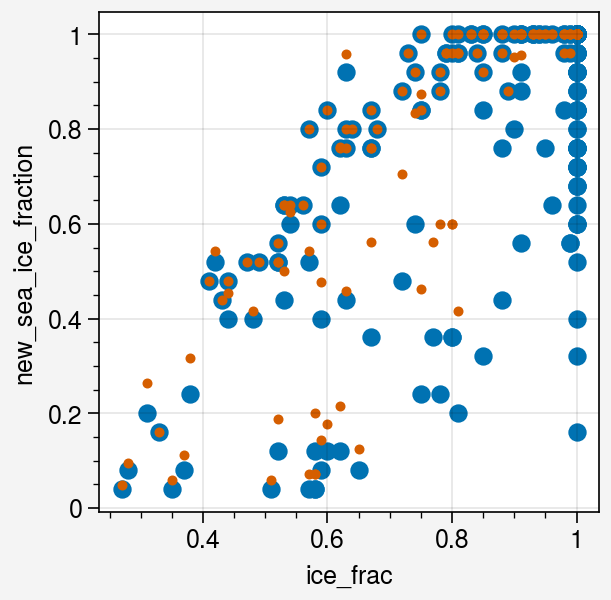

In [78]:
import proplot as pplt
fig, ax = pplt.subplots()
ax.scatter(all_cases.ice_frac, all_cases.new_sea_ice_fraction)
ax.scatter(all_cases.ice_frac, all_cases.new_sea_ice_fraction/(1-all_cases.new_mask_fraction), marker='.')

What I'm finding: there were a few different kinds of errors in my sea ice concentration calculation. My new calculation seems more reliable. 

In [82]:
all_cases['adj_ice_fraction'] = all_cases.new_sea_ice_fraction/(1-all_cases.new_mask_fraction)

In [83]:
all_cases.sort_values('new_sea_ice_fraction').loc[:, ['region', 'start_date', 'ice_frac', 'new_sea_ice_fraction', 'adj_ice_fraction']].head(25)

,region,start_date,ice_frac,new_sea_ice_fraction,adj_ice_fraction
case_number,,,,,
341,hudson_bay,2021-09-15,0.35,0.04,0.058824
437,sea_of_okhostk,2019-08-21,0.58,0.04,0.071429
398,sea_of_okhostk,2007-07-17,0.51,0.04,0.058824
434,sea_of_okhostk,2017-07-23,0.58,0.04,0.071429
166,bering_strait,2009-08-02,0.27,0.04,0.047619
406,sea_of_okhostk,2011-08-28,0.57,0.04,0.071429
161,bering_strait,2007-07-26,0.65,0.08,0.125000
194,bering_strait,2022-09-09,0.37,0.08,0.111111
430,sea_of_okhostk,2015-07-12,0.59,0.08,0.142857


# Sample code: this section was already run, re-running it will lead to a different sample

In [ ]:
region = 'bering_strait'
sic_dataloc = '/Users/dwatkin2/Documents/research/data/nsidc_daily_cdr/'

crs0 = pyproj.CRS('WGS84')
crs1 = pyproj.CRS('epsg:3413')
transformer_ll = pyproj.Transformer.from_crs(crs1, crs_to=crs0, always_xy=True)

candidates = []
n_samples=10
margin = 250e3
for region in locations.index:
    lon, lat = locations.loc[region, ['center_lon', 'center_lat']]
    box = draw_box(lon, lat, locations.loc[site, 'dx']-margin, locations.loc[site, 'dy']-margin)
    if region == 'sea_of_okhostk':
        months_sampled = pd.Series(np.zeros(6), index=np.arange(3, 9))
    else:
        months_sampled = pd.Series(np.zeros(7), index=np.arange(3, 10))

    while np.any(months_sampled < n_samples):
        # Randomly select date
        year = np.random.choice(np.arange(2003, 2023))
        remaining_months = list(months_sampled[months_sampled < n_samples].index)
        month = np.random.choice(remaining_months)
        days_in_month = pd.to_datetime(str(year) + '-' + str(month) + '-01').daysinmonth
        day = np.random.choice(np.arange(1, days_in_month+1))
        
        # Select region with sea ice concentration between 15 and 85 percent
        date = str(year) + str(month).zfill(2) + str(day).zfill(2)
        
        files = os.listdir(sic_dataloc + str(year))
        for f in files:
            if date in f:
                break
        if (f == files[-1]) & (date not in f):
            print('SIC file not found for date ', date)
    
        else:
            result = check_sic(sic_dataloc + str(year) + '/' + f, box)
            if len(result) > 0:
                center_x, center_y, with_ice = result
                lon0, lat0 = transformer_ll.transform(center_x, center_y)
                candidates.append([region, pd.to_datetime(date).strftime('%Y-%m-%d'), lon0, lat0, center_x, center_y, with_ice])               
                months_sampled[month] += 1
        # make this one a function that returns either None or with_ice.data

candidates = pd.DataFrame(candidates, columns=['region', 'start_date', 'center_lon', 'center_lat', 'center_x', 'center_y', 'ice_frac'])
# chukchi_march = candidates.copy()

candidates['month'] = pd.to_datetime(candidates['start_date'].values).month
candidates.groupby(['region', 'month']).count().pivot_table(index='region', columns='month', values='start_date')

candidates['ice_frac'] = candidates['ice_frac'].astype(float).round(2)
candidates.to_csv('../data/candidate_validation_table.csv')

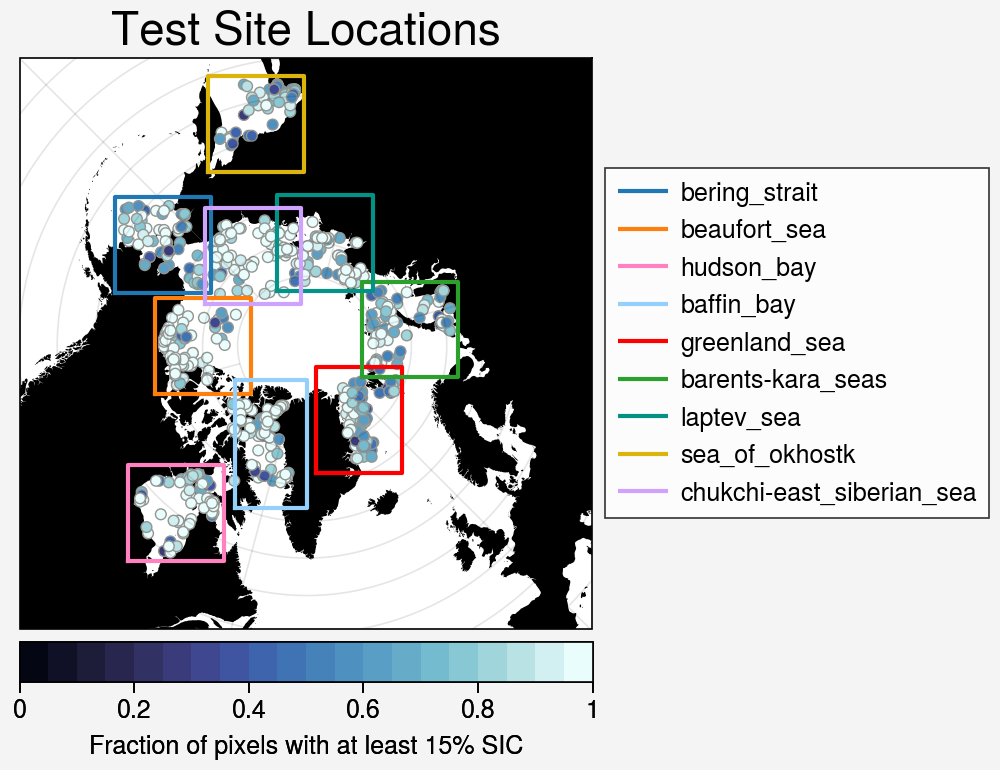

In [254]:
import warnings
import cartopy.crs as ccrs
warnings.simplefilter('ignore')
pplt.rc['reso'] = 'med'
fig, ax = pplt.subplots(width=5, proj='npstere', proj_kw={'lon_0': -45})
ax.format(land=True, color='k', boundinglat=50, landzorder=0)
h, l = [],[]
for site, color, lat, lon in zip(locations.index, locations.color, 
                                 locations.center_lat, locations.center_lon):
    xbox, ybox = draw_box(lon, lat, length_x=locations.loc[site, 'dx'], length_y=locations.loc[site, 'dy'])
    ax.plot(xbox, ybox, ls='-', m='', color=color, zorder=5,
            transform=ccrs.CRS('epsg:3413'), label=site)  
# ax.legend(loc='b')
c = ax.scatter(candidates['center_x'], candidates['center_y'], c=candidates['ice_frac'],
           ms=15, m='o', transform=ccrs.CRS('epsg:3413'), label='',
               vmin=0, vmax=1, cmap='ice', edgecolor='gray', ew=0.5, N=20)
ax.legend(loc='r', ncols=1)
ax.colorbar(c, loc='b', label='Fraction of pixels with at least 15% SIC')
ax.format(title='Test Site Locations', fontsize=15)
fig.save('../figures/location_map_example_sites.jpg', dpi=300)

# Accessing imagery

In [263]:
import pandas as pd
import numpy as np
import pyproj
candidates = pd.read_csv('../data/candidate_validation_table.csv', index_col=0)
candidates['start_date'] = pd.to_datetime(candidates['start_date'].values)
candidates['month'] = candidates['start_date'].dt.month
candidates['end_date'] = candidates['start_date'] + pd.to_timedelta('24H')
# candidates['end_date'] = candidates['end_date'].astype(str)
candidates['dx'] = np.nan
candidates['dy'] = np.nan
candidates = candidates.loc[~candidates.start_date.duplicated(keep='first')]

month,3,4,5,6,7,8,9
region,,,,,,,
baffin_bay,10,10,10,8,9,9,9
barents-kara_seas,8,10,9,10,9,9,10
beaufort_sea,10,9,9,10,10,10,10
bering_strait,10,10,10,10,10,10,10
chukchi-east_siberian_sea,7,8,10,9,9,9,10
greenland_sea,10,8,10,8,9,7,8
hudson_bay,10,10,10,10,10,10,10
laptev_sea,9,10,10,8,10,10,9
sea_of_okhostk,8,9,8,8,10,9,0


The goal of the sampling strategy is to have enough samples to check whether there are seasonal or regional differences in the errors in the IFT retrievals. We are time-limited in the sample selection, since validation by hand is a slow processes. To increase the number of samples in time, we include a relatively large number of small images (100 km) in the validation dataset.

9 regions, March-September (7 months)

2 full image per region 

6 1,000 km images per region

10 500 km images per region

21 100 km images per region

In [265]:
# full images
n_full = 2
# 1000 km images
n_1000km = 6
# 500 km images
n_500km = 10
# 100 km images
n_100km = 3
total = 9*(n_full + n_1000km + n_500km + (n_100km*7))
total

351

In [27]:
# Simple script to make a 20-year location dataset for IFT
# temp = locations.loc['greenland_sea', ['center_lat','center_lon','top_left_lat',
#                   'top_left_lon','lower_right_lat','lower_right_lon','left_x','right_x','lower_y','top_y']] #,startdate,enddate
# start = ['{y}-04-01 00:00'.format(y=year) for year in range(2003, 2023)]
# end = ['{y}-08-31 00:00'.format(y=year) for year in range(2003, 2023)]

# case_list = []
# for idx in range(len(start)):
#     case_list.append(temp)
# case_list = pd.DataFrame(case_list).reset_index()
# case_list.rename({'index': 'location'}, axis=1, inplace=True)
# for c in case_list.columns:
#     if c in ['left_x', 'right_x', 'lower_y', 'top_y']:
#         case_list[c] = case_list[c].round(0) # Don't need more than 1 m resolution for 250 m resolution data!
# case_list['startdate'] = start
# case_list['enddate'] = end
# case_list.to_csv('/Users/dwatkin2/Documents/research/manuscripts/greenland_absolute_dispersion/data/IFT_config/location_specification.csv', index=False)

In [268]:
# First, sample by month
sel = candidates.dx.isnull()
group = candidates.loc[sel, :].groupby(['region', 'month'], group_keys=False).apply(
    lambda x: x.sample(n_100km, random_state=np.random.seed + 1))
for col in ['dx', 'dy']:
    candidates.loc[group.index, col] = 100e3
    
# additional for sea of okhostk
sel = (candidates.region == 'sea_of_okhostk') & (candidates.dx.isnull())
addtl = candidates.loc[sel,:].sample(3, random_state=np.random.seed + 2)
candidates.loc[addtl.index, ['dx', 'dy']] = 100e3

# Full frame
update = candidates.copy()
group = candidates.groupby(['region'], group_keys=False).apply(lambda x: x.sample(n_full, random_state=np.random.seed + 3))
for col in ['dx', 'dy', 'center_lon', 'center_lat', 'center_x', 'center_y']:
    update.loc[group.index, col] = locations.loc[group.region, col].values
candidates = pd.concat([candidates, update.loc[group.index,:]]).reset_index(drop=True)

# 1000 km
sel = candidates.dx.isnull()
group = candidates.loc[sel, :].groupby('region', group_keys=False).apply(
    lambda x: x.sample(n_1000km, random_state=np.random.seed + 4))
for col in ['dx', 'dy']:
    candidates.loc[group.index, col] = 1000e3
    
sel = candidates.dx.isnull()
group = candidates.loc[sel, :].groupby('region', group_keys=False).apply(
    lambda x: x.sample(n_500km, random_state=np.random.seed + 5))
for col in ['dx', 'dy']:
    candidates.loc[group.index, col] = 500e3
    


In [271]:
candidates.dropna().groupby(
    ['region', 'dx']).count().pivot_table(
    index='region', values='start_date', columns='dx').fillna(0).astype(int)

dx,100000.0,500000.0,1000000.0,1125000.0,1350000.0,1500000.0
region,,,,,,
baffin_bay,21,10,6,2,0,0
barents-kara_seas,21,10,6,0,0,2
beaufort_sea,21,10,6,0,0,2
bering_strait,21,10,6,0,0,2
chukchi-east_siberian_sea,21,10,6,0,0,2
greenland_sea,21,10,6,0,2,0
hudson_bay,21,10,6,0,0,2
laptev_sea,21,10,6,0,0,2
sea_of_okhostk,21,10,6,0,0,2


In [279]:
candidates = candidates.dropna()
candidates = candidates.loc[:, ['region', 'start_date',  'month', 'center_lon', 'center_lat', 'center_x',
       'center_y', 'ice_frac', 'dx', 'dy']].reset_index(drop=True)
candidates['start_date'] = pd.to_datetime(candidates['start_date'])
candidates['end_date'] = candidates['start_date'] + pd.to_timedelta('1D')
sel = candidates.dx == 500e3
trajectory_checks = candidates.loc[sel,:].groupby('region', group_keys=False).apply(lambda x: x.sample(2, random_state=np.random.seed + 6))
extended_end_date = trajectory_checks['end_date'] + pd.to_timedelta('5D')
candidates.loc[extended_end_date.index, 'end_date'] = extended_end_date

candidates.dropna().reset_index(drop=True).to_csv('../data/cases_stratified_sample.csv')

In [236]:
candidates_reduced.to_csv('../data/cases_stratified_sample.csv')

# Second part
Downloading the data with the stratified sample

In [8]:
import os
import pandas as pd
import pyproj

def find_box(center_lon, center_lat, length_x, length_y, return_coords='stere'):
    """Find the coordinates of each corner for a box centered at center_lon, center_lat. Length in m."""
#     pol_stere_projection = '+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +a=6378273 +b=6356752.3142 +units=m +no_defs'
    crs0 = pyproj.CRS('WGS84')
    crs1 = pyproj.CRS('epsg:3413')
    transformer_xy = pyproj.Transformer.from_crs(crs0, crs_to=crs1, always_xy=True)
    transformer_ll = pyproj.Transformer.from_crs(crs1, crs_to=crs0, always_xy=True)
    center_x, center_y = transformer_xy.transform(center_lon, center_lat)
    dx = length_x/2
    dy = length_y/2
    left = center_x - dx
    right = center_x + dx
    top = center_y + dy
    bottom = center_y - dy
    
    topleft_lon, topleft_lat = transformer_ll.transform(left, top)
    topright_lon, topright_lat = transformer_ll.transform(right, top)
    bottomleft_lon, bottomleft_lat = transformer_ll.transform(left, bottom)
    bottomright_lon, bottomright_lat = transformer_ll.transform(right, bottom)
    
    return pd.Series([topleft_lat, topright_lat, bottomleft_lat, bottomright_lat,
                      topleft_lon, topright_lon, bottomleft_lon, bottomright_lon,
                      left, right, bottom, top],
                      index=['top_left_lat', 'top_right_lat', 'lower_left_lat', 'lower_right_lat',
                             'top_left_lon', 'top_right_lon', 'lower_left_lon', 'lower_right_lon',
                             'left_x', 'right_x', 'lower_y', 'top_y']).round(5)


locations = pd.read_csv('../data/site_locations.csv', index_col=0)
cases = pd.read_csv('../data/cases_stratified_sample.csv', index_col=0)
cases['start_date'] = pd.to_datetime(cases['start_date'].values)
cases['end_date'] = pd.to_datetime(cases['end_date'].values)
cases['month'] = cases['start_date'].dt.month

In [9]:
# format for overview document
cases = cases.sort_values(['region', 'start_date']).reset_index(drop=True)
cases_pretty = cases.loc[:, ['region', 'start_date', 'end_date', 'center_lon', 'center_lat', 'center_x', 'center_y', 'ice_frac', 'dx', 'dy']]
cases_pretty['dx'] = (cases_pretty['dx']/1e3).round(0).astype(int)
cases_pretty['dy'] = (cases_pretty['dy']/1e3).round(0).astype(int)
cases_pretty.rename({'dx': 'dx_km', 'dy': 'dy_km'}, axis=1, inplace=True)
# Expand the 5-day series for easier tracking of work completed
new_row_dfs = []
for case_num in cases_pretty.loc[cases_pretty.dx_km == 500].index:
    startdates = pd.date_range(cases_pretty.loc[case_num, 'start_date'],
                               cases_pretty.loc[case_num, 'end_date']-pd.to_timedelta('1D'), freq='1D')
    if len(startdates) > 1:
        new_rows = []
        for new_date in startdates[1:]:
            new_row = cases_pretty.loc[case_num,:].copy()
            new_row['start_date'] = new_date
            new_rows.append(new_row)
        new_row_dfs.append(pd.concat(new_rows, axis=1).T.reset_index(drop=True))

cases_pretty = pd.concat([cases_pretty, pd.concat(new_row_dfs, axis=0)], axis=0).sort_values(['region', 'start_date'])
# cases_pretty.drop('end_date', axis=1).reset_index(drop=True).to_csv('../data/master_case_list.csv')

In [292]:
## Only need to run once
# This builds the directory
saveloc = '../data/validation_images/'
for region in locations.index:
    os.mkdir(saveloc + region)
    
for idx in cases.index:
    region = cases.loc[idx, 'region']
    start_date = cases.loc[idx, 'start_date'].strftime('%Y%m%d')
    end_date = cases.loc[idx, 'end_date'].strftime('%Y%m%d')
    dx = int(cases.loc[idx, 'dx']/1e3)
    dy = int(cases.loc[idx, 'dy']/1e3)
    imsize = str(dx) + 'km_by_' + str(dy) + 'km'
    if imsize not in os.listdir(saveloc + region):
        os.mkdir(saveloc + region + '/' + imsize)
        
    os.mkdir(saveloc + region + '/' + imsize + '/' + start_date + '_' + end_date)

In [32]:
locations = pd.read_csv('../data/site_locations.csv')
cases = pd.read_csv('../data/master_case_list.csv', index_col=0)
cases['start_date'] = pd.to_datetime(cases['start_date'].values)
cases['end_date'] = [pd.to_datetime(x) + pd.to_timedelta('1D') for x in cases['start_date'].values]
cases['dx'] = cases['dx_km']*1e3
cases['dy'] = cases['dy_km']*1e3
cases.loc[cases.region == 'hudson_bay']

,region,start_date,center_lon,center_lat,center_x,center_y,ice_frac,dx_km,dy_km,end_date,dx,dy
294,hudson_bay,2003-08-24,-84.980146,66.094187,-1.687500e+06,-2.012500e+06,0.77,1000,1000,2003-08-25,1000000.0,1000000.0
295,hudson_bay,2003-08-25,-86.355510,64.728895,-1.837500e+06,-2.087500e+06,0.81,100,100,2003-08-26,100000.0,100000.0
296,hudson_bay,2004-07-06,-77.999790,56.421908,-2.037500e+06,-3.137500e+06,0.89,100,100,2004-07-07,100000.0,100000.0
297,hudson_bay,2004-09-03,-86.401232,64.418360,-1.862500e+06,-2.112500e+06,0.75,100,100,2004-09-04,100000.0,100000.0
298,hudson_bay,2005-04-09,-91.984703,57.853010,-2.612500e+06,-2.437500e+06,1.00,100,100,2005-04-10,100000.0,100000.0
299,hudson_bay,2005-05-12,-83.000000,60.000000,-2.045942e+06,-2.618686e+06,1.00,1500,1500,2005-05-13,1500000.0,1500000.0
300,hudson_bay,2005-06-13,-84.081940,63.554584,-1.837500e+06,-2.262500e+06,0.91,100,100,2005-06-14,100000.0,100000.0
301,hudson_bay,2006-03-29,-76.134533,63.885902,-1.487500e+06,-2.462500e+06,1.00,100,100,2006-03-30,100000.0,100000.0
302,hudson_bay,2006-04-03,-76.820132,63.958479,-1.512500e+06,-2.437500e+06,1.00,100,100,2006-04-04,100000.0,100000.0
303,hudson_bay,2006-09-04,-86.260497,65.351006,-1.787500e+06,-2.037500e+06,0.81,500,500,2006-09-05,500000.0,500000.0


In [28]:
 cases.loc[case_num, ]

region                 hudson_bay
start_date    2017-07-16 00:00:00
center_lon             -81.308692
center_lat              64.494614
center_x               -1662500.0
center_y               -2262500.0
ice_frac                     0.67
dx_km                         100
dy_km                         100
Name: 334, dtype: object

In [33]:
# Getting single case for Hudson Bay that was missing
fetchdata_path = '../scripts/fetchdata.sh'
saveloc = '/Users/dwatkin2/Documents/research/manuscripts/cal-val_ice_floe_tracker/data/validation_images/'
temploc = saveloc + 'temp/'

regions = ['hudson_bay']
# 100 km only
for region in regions:
    n = len(cases.loc[cases.region == region])
    for idx, case_num in enumerate(cases.loc[(cases.region == region)].index):
        # get save location
        region = cases.loc[case_num, 'region']
        startdate = cases.loc[case_num, 'start_date'].strftime('%Y-%m-%d')
        enddate = cases.loc[case_num, 'end_date'].strftime('%Y-%m-%d')        
        dx = int(cases.loc[case_num, 'dx']/1e3)
        dy = int(cases.loc[case_num, 'dy']/1e3)
        imsize = str(dx) + 'km_by_' + str(dy) + 'km'
        savepath = saveloc + region + '/' + imsize + '/' + startdate.replace('-', '') + '_' + enddate.replace('-', '') + '/'
        print(str(idx) + '/' + str(n), region, imsize, startdate, enddate)
        coords = find_box(cases.loc[case_num, 'center_lon'],
                          cases.loc[case_num, 'center_lat'],
                          cases.loc[case_num, 'dx'],
                          cases.loc[case_num, 'dy'])
        crs = 'wgs84'
        # bounding_box = ','.join(list(coords[['left_x', 'lower_y', 'right_x', 'top_y']].astype(int).astype(str)))
        bounding_box = '@'.join(list(coords[['top_left_lat', 'top_left_lon', 'lower_right_lat', 'lower_right_lon']].round(5).astype(str)))

        startdates = pd.date_range(cases.loc[case_num, 'start_date'], cases.loc[case_num, 'end_date']-pd.to_timedelta('1D'), freq='1D')
        for startdate in startdates:
            startdate = startdate.strftime('%Y-%m-%d')
            # first download the iamges to temp
            ! $fetchdata_path -o $temploc -s $startdate -e $enddate -b $bounding_box -c $crs

            ! rm -r ${savepath}
            
            ! cp {temploc}landmask.tiff {savepath}.
            tcfiles = os.listdir(temploc + 'truecolor')
            fcfiles = os.listdir(temploc + 'reflectance')
            if 'truecolor' not in os.listdir(savepath):
                os.mkdir(savepath + '/truecolor')
            if 'falsecolor' not in os.listdir(savepath):
                os.mkdir(savepath + '/falsecolor')

            for f in tcfiles:
                if 'tiff' in f:
                    ! cp {temploc}truecolor/{f} {savepath}truecolor/.
            for f in fcfiles:
                    ! cp {temploc}reflectance/{f} {savepath}falsecolor/.
            ! rm {temploc}landmask.tiff
            ! rm -r {temploc}reflectance
            ! rm -r {temploc}truecolor

0/49 hudson_bay 1000km_by_1000km 2003-08-24 2003-08-25
downloading landmask
downloading true color images
.
downloading reflectance color images
.
rm: $/Users/dwatkin2/Documents/research/manuscripts/cal-val_ice_floe_tracker/data/validation_images/hudson_bay/1000km_by_1000km/20030824_20030825/: No such file or directory
1/49 hudson_bay 100km_by_100km 2003-08-25 2003-08-26
downloading landmask
downloading true color images
.
downloading reflectance color images
.
rm: $/Users/dwatkin2/Documents/research/manuscripts/cal-val_ice_floe_tracker/data/validation_images/hudson_bay/100km_by_100km/20030825_20030826/: No such file or directory
2/49 hudson_bay 100km_by_100km 2004-07-06 2004-07-07
downloading landmask
downloading true color images
.
downloading reflectance color images
.
rm: $/Users/dwatkin2/Documents/research/manuscripts/cal-val_ice_floe_tracker/data/validation_images/hudson_bay/100km_by_100km/20040706_20040707/: No such file or directory
3/49 hudson_bay 100km_by_100km 2004-09-03 200

FileNotFoundError: [Errno 2] No such file or directory: '/Users/dwatkin2/Documents/research/manuscripts/cal-val_ice_floe_tracker/data/validation_images/hudson_bay/500km_by_500km/20060904_20060905/'

In [10]:
fetchdata_path = '../scripts/fetchdata.sh'
saveloc = '/Users/dwatkin2/Documents/research/manuscripts/cal-val_ice_floe_tracker/data/validation_images/'
temploc = saveloc + 'temp/'

regions = [ 'beaufort_sea', 'hudson_bay', 'baffin_bay', 'greenland_sea', 'bering_strait',
           'barents-kara_seas', 'laptev_sea', 'sea_of_okhostk', 'chukchi-east_siberian_sea']

# 100 km only
cases = cases.loc[cases.dx == 100e3]

for region in regions:
    n = len(cases.loc[cases.region == region])
    for idx, case_num in enumerate(cases.loc[(cases.region == region)].index):
        # get save location
        region = cases.loc[case_num, 'region']
        startdate = cases.loc[case_num, 'start_date'].strftime('%Y-%m-%d')
        enddate = cases.loc[case_num, 'end_date'].strftime('%Y-%m-%d')        
        dx = int(cases.loc[case_num, 'dx']/1e3)
        dy = int(cases.loc[case_num, 'dy']/1e3)
        imsize = str(dx) + 'km_by_' + str(dy) + 'km'
        savepath = saveloc + region + '/' + imsize + '/' + startdate.replace('-', '') + '_' + enddate.replace('-', '') + '/'
        print(str(idx) + '/' + str(n), region, imsize, startdate, enddate)
        coords = find_box(cases.loc[case_num, 'center_lon'],
                          cases.loc[case_num, 'center_lat'],
                          cases.loc[case_num, 'dx'],
                          cases.loc[case_num, 'dy'])
        crs = 'wgs84'
        # bounding_box = ','.join(list(coords[['left_x', 'lower_y', 'right_x', 'top_y']].astype(int).astype(str)))
        bounding_box = '@'.join(list(coords[['top_left_lat', 'top_left_lon', 'lower_right_lat', 'lower_right_lon']].round(5).astype(str)))

        startdates = pd.date_range(cases.loc[case_num, 'start_date'], cases.loc[case_num, 'end_date']-pd.to_timedelta('1D'), freq='1D')
        for startdate in startdates:
            startdate = startdate.strftime('%Y-%m-%d')
            # first download the iamges to temp
            ! $fetchdata_path -o $temploc -s $startdate -e $enddate -b $bounding_box -c $crs

            ! rm -r ${savepath}
            
            ! cp {temploc}landmask.tiff {savepath}.
            tcfiles = os.listdir(temploc + 'truecolor')
            fcfiles = os.listdir(temploc + 'reflectance')
            if 'truecolor' not in os.listdir(savepath):
                os.mkdir(savepath + '/truecolor')
            if 'falsecolor' not in os.listdir(savepath):
                os.mkdir(savepath + '/falsecolor')

            for f in tcfiles:
                if 'tiff' in f:
                    ! cp {temploc}truecolor/{f} {savepath}truecolor/.
            for f in fcfiles:
                    ! cp {temploc}reflectance/{f} {savepath}falsecolor/.
            ! rm {temploc}landmask.tiff
            ! rm -r {temploc}reflectance
            ! rm -r {temploc}truecolor


0/21 beaufort_sea 100km_by_100km 2003-04-22 2003-04-23
downloading landmask
downloading true color images
.
downloading reflectance color images
.
rm: $/Users/dwatkin2/Documents/research/manuscripts/cal-val_ice_floe_tracker/data/validation_images/beaufort_sea/100km_by_100km/20030422_20030423/: No such file or directory
1/21 beaufort_sea 100km_by_100km 2003-05-27 2003-05-28
downloading landmask
downloading true color images
.
downloading reflectance color images
.
rm: $/Users/dwatkin2/Documents/research/manuscripts/cal-val_ice_floe_tracker/data/validation_images/beaufort_sea/100km_by_100km/20030527_20030528/: No such file or directory
2/21 beaufort_sea 100km_by_100km 2003-06-16 2003-06-17
downloading landmask
downloading true color images
.
downloading reflectance color images
.
rm: $/Users/dwatkin2/Documents/research/manuscripts/cal-val_ice_floe_tracker/data/validation_images/beaufort_sea/100km_by_100km/20030616_20030617/: No such file or directory
3/21 beaufort_sea 100km_by_100km 2003

In [55]:
! ls ${temploc}truecolor/

ls: $/Users/dwatkin2/Documents/research/manuscripts/cal-val_ice_floe_tracker/data/validation_images/temp/truecolor/: No such file or directory


Next steps:
- Ellen can provide the cloud fraction for each candidate point
- Climatology of sea ice concentration in each box
- Timing of sunlit season by box
- Description of sampling strategy on Overleaf
- Figure with wireframes
- I think that only the first day downloads for the 5-day examples, so adjust the loop for those

In [64]:
# for each region
locations = pd.read_csv('../data/site_locations.csv', index_col=0)
print(locations.index)


Index(['bering_strait', 'beaufort_sea', 'hudson_bay', 'baffin_bay',
       'greenland_sea', 'barents-kara_seas', 'laptev_sea', 'sea_of_okhostk',
       'chukchi-east_siberian_sea'],
      dtype='object', name='location')


In [83]:
locations.columns

Index(['color', 'center_lat', 'center_lon', 'center_x', 'center_y',
       'top_left_lat', 'top_left_lon', 'lower_left_lat', 'lower_left_lon',
       'dx', 'dy'],
      dtype='object')

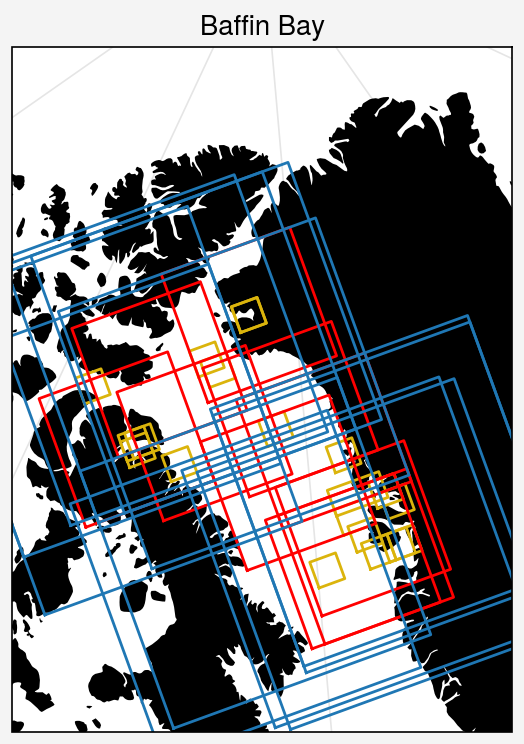

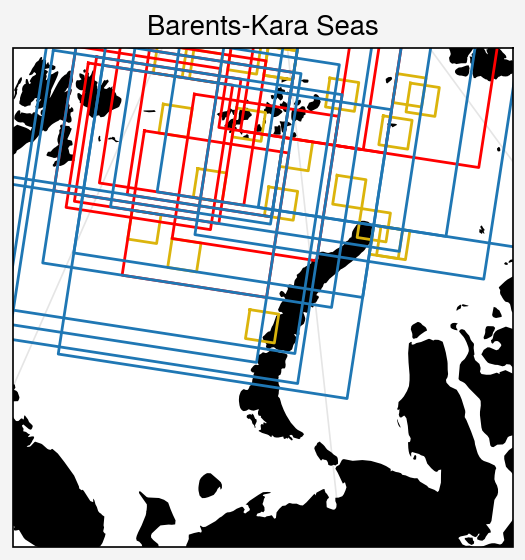

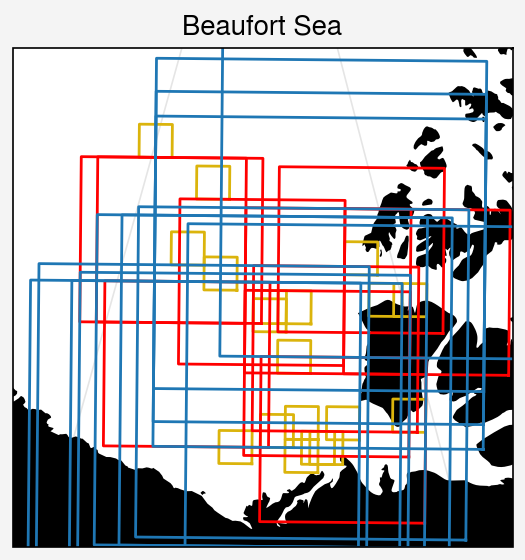

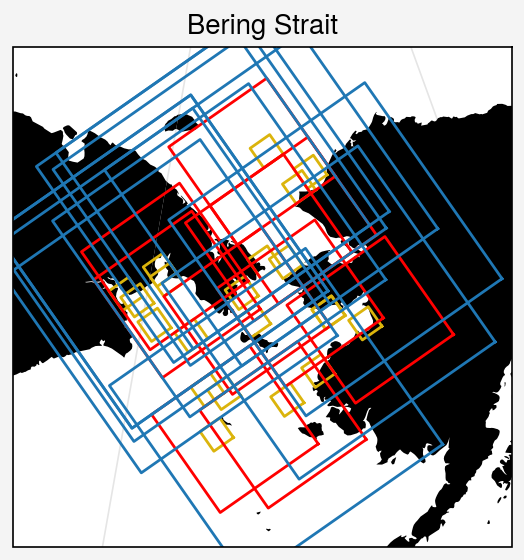

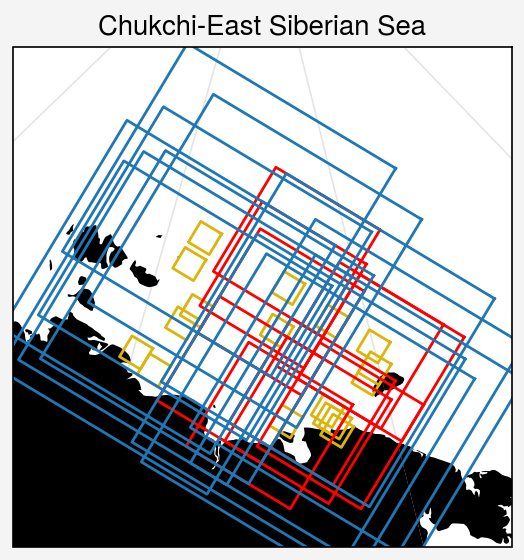

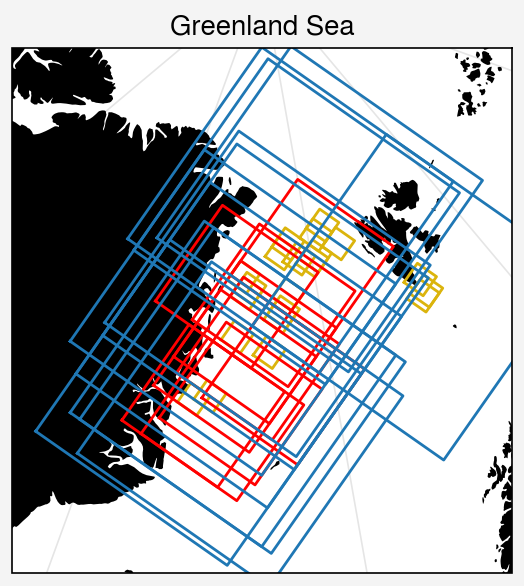

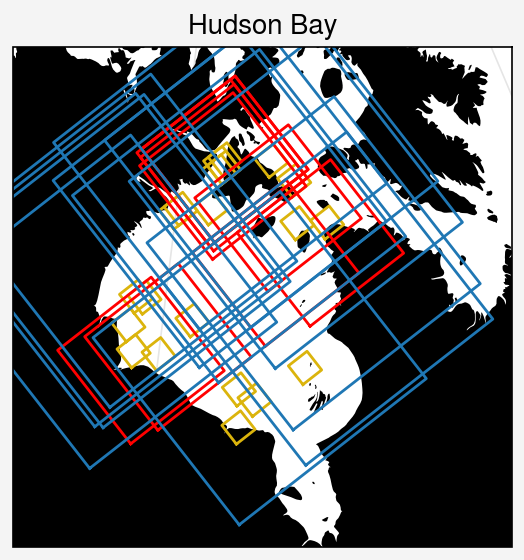

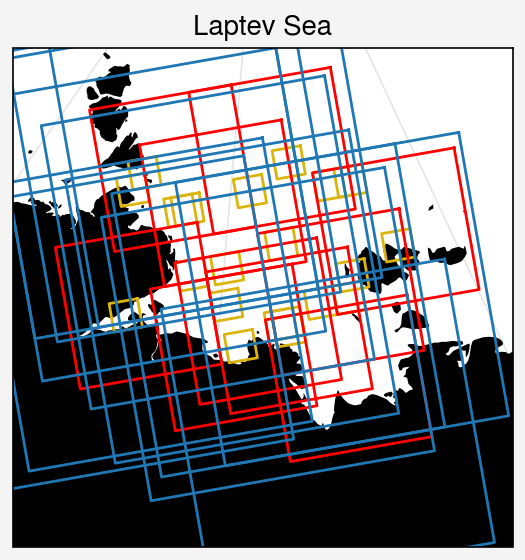

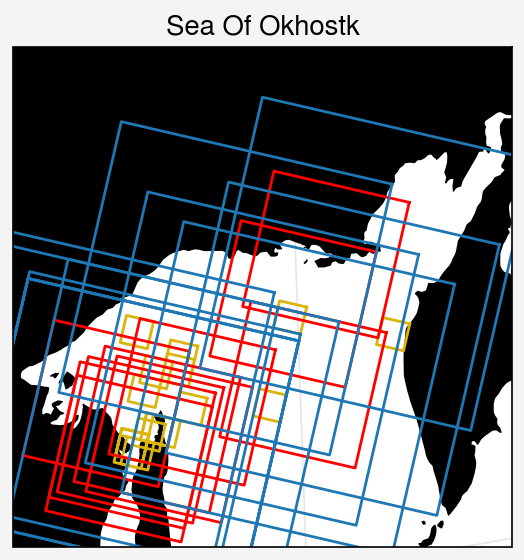

In [73]:
import cartopy.crs as ccrs
CRS = ccrs.epsg(3413)
pplt.rc.reso='med'
pplt.rc['cartopy.circular'] = False

for region, group in candidates.groupby('region'):
    box = draw_box(locations.loc[region, 'center_lon'], locations.loc[region, 'center_lat'],
             locations.loc[region, 'dx'], locations.loc[region, 'dy'])
    coords = find_box(locations.loc[region, 'center_lon'],
                      locations.loc[region, 'center_lat'],
                      locations.loc[region, 'dx'],
                      locations.loc[region, 'dy'])

    fig, ax = pplt.subplots(proj='npstere', proj_kw={'lon_0': locations.loc[region, 'center_lon']})
    ax.format(land=True, lonlocator=np.arange(0, 360, 30), latlocator=(50, 90, 5), latmax=90)
    ax.set_extent([coords.left_x, coords.right_x, coords.top_y, coords.lower_y], crs=CRS)

    ax.format(title=region.replace('_', ' ').title())
    for size, color in zip([100e3, 500e3, 1000e3], ['gold', 'red', 'tab:blue']):    
        for case in group.index:
            if group.loc[case, 'dx'] == size:
                xbox, ybox = draw_box(group.loc[case, 'center_lon'], group.loc[case, 'center_lat'],
                     group.loc[case, 'dx'], group.loc[case, 'dy'])
                ax.plot(xbox, ybox, color=color, lw=1, transform=CRS)


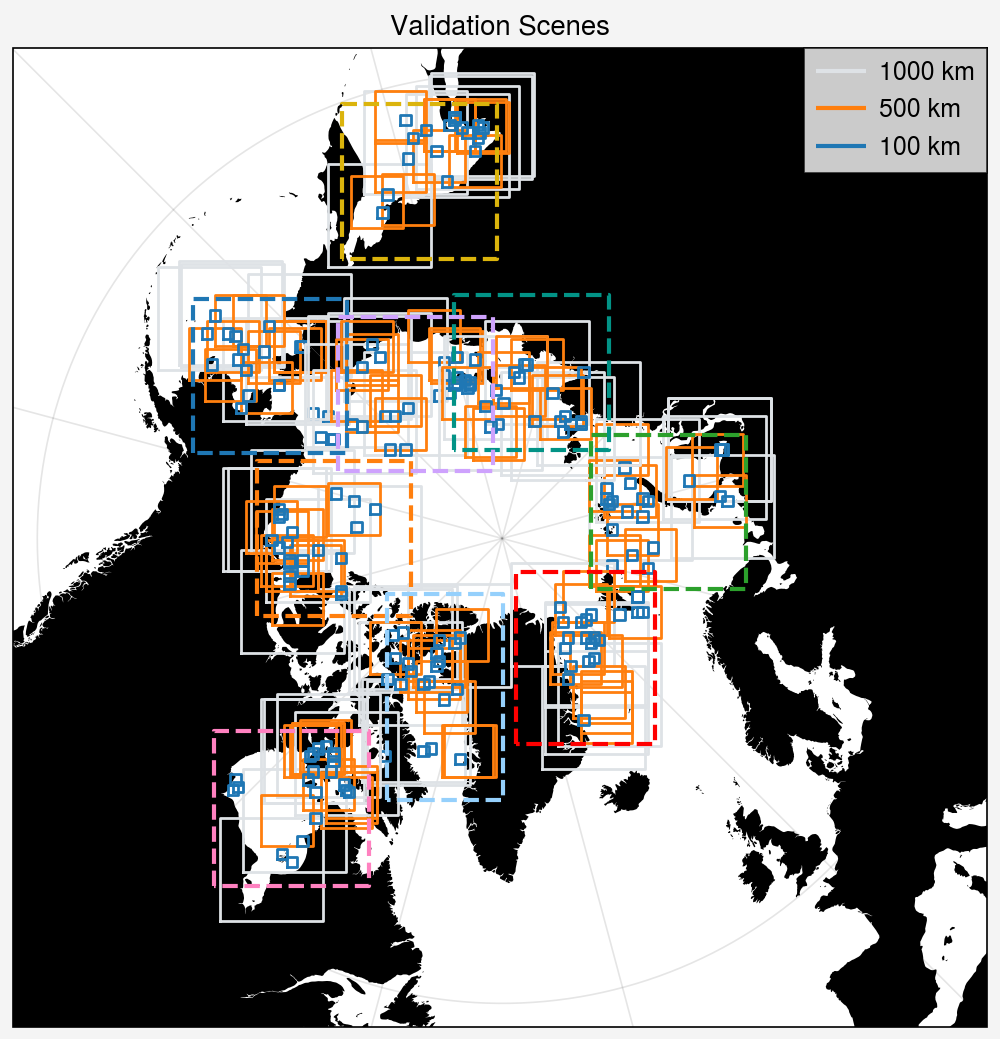

In [303]:
fig, ax = pplt.subplots(proj='npstere', proj_kw={'lon_0': -45}, width=5)
ax.format(land=True, lonlocator=np.arange(0, 361, 30), latlocator=(50, 90, 5), latmax=90,
         boundinglat=48)
# ax.set_extent([coords.left_x, coords.right_x, coords.top_y, coords.lower_y], crs=CRS)

for region, group in cases.groupby('region'):


    ax.format(title='Validation Scenes')
    for size, color in zip([1000e3, 500e3, 100e3], ['gray3', 'tab:orange', 'tab:blue']):    
        for case in group.index:
            if group.loc[case, 'dx'] == size:
                xbox, ybox = draw_box(group.loc[case, 'center_lon'], group.loc[case, 'center_lat'],
                     group.loc[case, 'dx'], group.loc[case, 'dy'])
                ax.plot(xbox, ybox, color=color, lw=1, transform=CRS)

h, l = [], []
for size, color in zip([1000e3, 500e3, 100e3], ['gray3', 'tab:orange', 'tab:blue']):    
    h.append(ax.plot([],[], color=color))
    l.append(str(int(size/1e3)) + ' km')
ax.legend(h, l, ncols=1)

for region in locations.index:
    xbox, ybox = draw_box(locations.loc[region, 'center_lon'], locations.loc[region, 'center_lat'],
             locations.loc[region, 'dx'], locations.loc[region, 'dy'])
    color = locations.loc[region, 'color']
    ax.plot(xbox, ybox, c=color, transform=CRS, ls='--')
fig.save('../figures/sample_selection_wireframe_map.jpg', dpi=300)

In [90]:
# The 100 km and 500 km boxes are strictly inside the cases, or should be,
# but the 1000 km boxes overlap the edges. Is that good or bad?

Examples of single cases from each location for Tim

In [17]:
locations = pd.read_csv('../data/site_locations.csv')
candidates = pd.read_csv('../data/master_case_list.csv', index_col=0)

In [15]:
case = candidates.loc[3,:]
case = find_box(case.center_lon,
          case.center_lat,
          case.dx_km,
          case.dy_km).round(3)

AttributeError: 'Series' object has no attribute 'dx_km'

In [18]:
candidates

,region,start_date,center_lon,center_lat,center_x,center_y,ice_frac,dx_km,dy_km
0,baffin_bay,2004-07-25,-65.289201,69.901354,-762500.0,-2062500.0,1.00,100,100
1,baffin_bay,2004-07-26,-68.290117,71.194043,-812500.0,-1887500.0,1.00,1000,1000
2,baffin_bay,2004-09-21,-73.300756,68.110950,-1137500.0,-2112500.0,0.88,100,100
3,baffin_bay,2005-06-07,-67.229621,75.735709,-587500.0,-1437500.0,1.00,500,500
4,baffin_bay,2005-08-19,-86.748054,75.688208,-1037500.0,-1162500.0,0.99,100,100
...,...,...,...,...,...,...,...,...,...
436,sea_of_okhostk,2019-06-22,137.675427,54.094691,-187500.0,4012500.0,0.68,1000,1000
437,sea_of_okhostk,2019-08-21,141.455552,53.285699,-462500.0,4087500.0,0.58,100,100
438,sea_of_okhostk,2020-04-21,150.288664,56.387895,-987500.0,3612500.0,0.28,500,500
439,sea_of_okhostk,2021-04-05,148.899063,55.932809,-912500.0,3687500.0,0.88,100,100


In [26]:
'@'.join([str(x) for x in [case['left_x'], case['top_y'], case['right_x'], case['lower_y']]])

'-587750.0@-1437250.0@-587250.0@-1437750.0'

In [38]:
'@'.join([str(x) for x in [case['top_left_lat'], case['top_left_lon'], case['lower_right_lat'], case['lower_right_lon']]])

'80.001@-17.00517@79.999@-16.99483'

In [36]:
"81@-22@79@-12"
case = find_box(-17, 80, 275, 100)


In [37]:
'@'.join([str(x) for x in [case['left_x'], case['top_y'], case['right_x'], case['lower_y']]])

'509671.19908@-958760.71262@509946.19908@-958860.71262'

In [8]:
left_x, top_y, right_x, bottom_y = [float(x) for x in '-837500.0@-1187500.0@-337500.0@-1687500.0'.split('@')]


In [9]:
crs0 = pyproj.CRS('WGS84')
crs1 = pyproj.CRS('epsg:3413')
transformer_ll = pyproj.Transformer.from_crs(crs1, crs_to=crs0, always_xy=True)
transformer_ll.transform(left_x, top_y), transformer_ll.transform(right_x, bottom_y)

((-80.19390724010292, 76.64418678475745),
 (-56.309932474020215, 74.2103653604851))

In [42]:
-172 lon, 55.9 lat
-163.8 lon, 74.25 lat

SyntaxError: invalid syntax (3917606167.py, line 1)

In [53]:
transformer_xy = pyproj.Transformer.from_crs(crs0, crs_to=crs1, always_xy=True)
transformer_xy.transform(-172.778, 55.928)

(-3002924.412913457, 2327460.690189773)

In [54]:
cx = -587500
cy = -1437500
'@'.join([str(x) for x in [cx - 250e3, cy + 250e3, cx + 250e3, cy - 250e3]])

'-837500.0@-1187500.0@-337500.0@-1687500.0'

In [55]:
transformer_ll.transform(cx, cy)

(-67.22962109123779, 75.73570921118771)

In [11]:
! mkdir ../data/baffin_bay


In [12]:
crs = 'wgs84'
bounding_box = '73.91696@-86.53177@73.78835@-81.95094'
saveloc = '../data/baffin_bay/'
startdate = '2019-05-23'
enddate = '2019-06-07'
fetchdata_path = '../scripts/fetchdata.sh'
! $fetchdata_path -o $temploc -s $startdate -e $enddate -b $bounding_box -c $crs

downloading landmask
downloading true color images
...............
downloading reflectance color images
...............


# Separating tables for simpler workflow
Here I'm pulling out just the 100 km cases for each location, and reordering columns.

In [1]:
import pandas as pd

/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_1490/4080736814.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('../../data/validation_overview _table_2024-01-29.csv')

In [5]:
for name, group in df.loc[df.dx_km == 100].groupby('region'):
    break
case_number = [str(x).zfill(3) for x in group['index']]
region = group['region']
start_date = group['start_date']
visible_floes = group['visible_floes']
cloud_fraction = group['cloud_fraction']
cloud_cat = group['cloud_category']


In [6]:
group

,index,region,start_date,center_lon,center_lat,center_x,center_y,ice_frac,dx_km,dy_km,analyst,reviewer,satellite,visible_floes,cloud_fraction,cloud_category,artifacts,floe_labels_complete,category_labels_complete
0,0,baffin_bay,2004-07-25,-65.289201,69.901354,-762500.0,-2062500.0,1.00,100,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,baffin_bay,2004-09-21,-73.300756,68.110950,-1137500.0,-2112500.0,0.88,100,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,baffin_bay,2005-08-19,-86.748054,75.688208,-1037500.0,-1162500.0,0.99,100,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,baffin_bay,2005-08-27,-93.576334,76.973657,-1062500.0,-937500.0,1.00,100,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,baffin_bay,2007-06-05,-64.798876,74.756837,-562500.0,-1562500.0,0.99,100,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,baffin_bay,2008-07-04,-63.645594,70.336879,-687500.0,-2037500.0,0.95,100,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,16,baffin_bay,2009-04-26,-69.550452,79.750680,-462500.0,-1012500.0,1.00,100,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,19,baffin_bay,2011-05-06,-72.284207,77.710993,-612500.0,-1187500.0,1.00,100,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,20,baffin_bay,2012-04-19,-79.579288,75.637235,-887500.0,-1287500.0,1.00,100,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,21,baffin_bay,2012-04-22,-72.255328,77.200903,-637500.0,-1237500.0,1.00,100,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
